In [26]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from src.augment_lib import Rozszerzanie
from src.specaugment import SpecAugment
from src.funkcje import load_audio, mfcc, apply_spec_augment, plot_history, extract_mfcc
from sklearn.model_selection import train_test_split

In [27]:
commands = ['Ciemniej', 'Jasniej', 'Muzyka', 'Rolety', 'Swiatlo', 'Telewizor', 'Wrocilem', 'Wychodze', 'Tlo']
username = os.getenv("USERNAME")
REC_PATH = rf"C:\Users\{username}\Desktop\Praca_dyplomowa_TensorFlow\Nagrania"
SR = 16000
DURATION = 1.0
for i in commands:
    os.makedirs(os.path.join(REC_PATH, i), exist_ok=True)
commands_paths = [os.path.join(REC_PATH, i) for i in commands]
print(commands_paths)

['C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Ciemniej', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Jasniej', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Muzyka', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Rolety', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Swiatlo', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Telewizor', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Wrocilem', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Wychodze', 'C:\\Users\\Hubert\\Desktop\\Praca_dyplomowa_TensorFlow\\Nagrania\\Tlo']


In [28]:
augmenter = Rozszerzanie()
zmywanie = librosa.load(r'background\doing_the_dishes.wav', sr=SR)[0]
kran = librosa.load(r'background\running_tap.wav', sr=SR)[0]
rower = librosa.load(r'background\exercise_bike.wav', sr=SR)[0]

augmenter.add_noise_to_library('zmywanie', zmywanie)
augmenter.add_noise_to_library('rower', rower)
augmenter.add_noise_to_library('kran', kran)

In [29]:
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

In [30]:
def process_data(file_paths,labels, augment=False,include_original=None):

    if include_original is None:
        include_original = not augment

    mfcc_features   = []
    processed_labels = []
    n_mfcc = 20

    for path, label in zip(file_paths, labels):
        audio     = load_audio(path, SR, DURATION)
        mfcc_orig = extract_mfcc(audio, sr=SR, n_mfcc=n_mfcc)

        if include_original:
            mfcc_features.append(mfcc_orig)
            processed_labels.append(tf.constant(label, dtype=tf.int32))

        if augment:
            if random.random() < 0.5:
                mfcc_aug, _ = apply_spec_augment(mfcc_orig, label)
            else:
                config = [
                    {'name': 'add_white_noise', 'p': 0.5,
                     'params': {'noise_factor': 0.06}},
                    {'name': 'time_stretch',   'p': 0.4,
                     'params': {'stretch_rate': random.uniform(0.9, 1.1),
                                'target_duration': DURATION}},
                    {'name': 'pitch_scale',    'p': 0.5,
                     'params': {'num_semitones': random.randint(-2, 2)}},
                    {'name': 'add_noise',      'p': 0.6,
                     'params': {'noise_options': [
                                    ["zmywanie", 0.4],
                                    ["kran",     0.3],
                                    ["rower",    0.3]
                                ],
                                'snr': random.randint(7, 20)}} 
                ]
                augmented_audio, _ = augmenter.apply_augmentation(
                    np.copy(audio),
                    label,
                    config,
                    debug=(random.random() < 0.05)
                )
                mfcc_aug = extract_mfcc(augmented_audio,
                                        sr=SR,
                                        n_mfcc=n_mfcc)

            mfcc_features.append(mfcc_aug)
            processed_labels.append(tf.constant(label, dtype=tf.int32))

    return mfcc_features, processed_labels

In [31]:
def load_and_label():
    commands_folder = {
        "Ciemniej": 0,
        "Jasniej": 1,
        "Muzyka": 2,
        "Rolety": 3,
        "Swiatlo": 4,
        "Telewizor": 5,
        "Wrocilem": 6,
        "Wychodze": 7,
        "Tlo": 8        
        }
    file_paths = []
    labels = []
    for folder, label in commands_folder.items():
        folder_path = os.path.join(REC_PATH, folder)
        if not os.path.exists(folder_path):
            print(f"Brak folderu: {folder_path}")
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(folder_path, file))
                labels.append(label)
    return file_paths, labels

In [32]:
all_files_names = []
for command_path in commands_paths:
    current_command_files = os.listdir(command_path)
    all_files_names.append(current_command_files)

print(len(all_files_names))
print(len(all_files_names[0]))

9
100


In [33]:
commands_files_count = {}
for index, command_all_files_names in  enumerate(all_files_names):
    commands_files_count[index] = len(command_all_files_names)
for index, count in commands_files_count.items():
    print(f'Ilosc plikow w klasie {index} = {count}')

Ilosc plikow w klasie 0 = 100
Ilosc plikow w klasie 1 = 100
Ilosc plikow w klasie 2 = 100
Ilosc plikow w klasie 3 = 100
Ilosc plikow w klasie 4 = 100
Ilosc plikow w klasie 5 = 100
Ilosc plikow w klasie 6 = 100
Ilosc plikow w klasie 7 = 100
Ilosc plikow w klasie 8 = 500


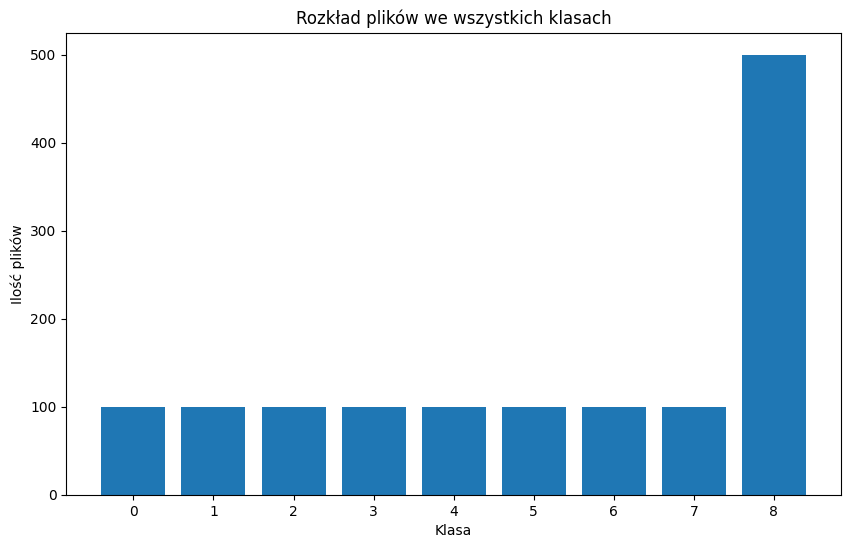

In [34]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(10, 6))
plt.bar(commands_files_count.keys(), commands_files_count.values())
plt.title('Rozkład plików we wszystkich klasach')
plt.xlabel('Klasa')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.ylabel('Ilość plików')
plt.show()

In [35]:
file_paths, labels = load_and_label()

In [36]:
print(file_paths[152], labels[152])
def generate_diverse_training_data(train_paths, train_labels, versions=1):
    all_X, all_y = [], []

    for v in range(versions):
        random.seed(42 + v * 1000)
        X_v, y_v = process_data(train_paths, train_labels, augment=True)
        all_X.extend(X_v)
        all_y.extend(y_v)
        print(f"Wersja {v+1}: {len(X_v)} próbek")

    return all_X, all_y

C:\Users\Hubert\Desktop\Praca_dyplomowa_TensorFlow\Nagrania\Jasniej\Jasniej_56.wav 1


In [37]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)
X_train_orig, y_train_orig = process_data(
    train_paths,
    train_labels,
    augment=False
)

X_train_aug, y_train_aug = generate_diverse_training_data(
    train_paths,
    train_labels,
    versions=5
)

X_train = X_train_orig + X_train_aug
y_train = y_train_orig + y_train_aug

X_test, y_test = process_data(
    test_paths,
    test_labels,
    augment=False
)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=9)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes=9)

Wersja 1: 1040 próbek
Wersja 2: 1040 próbek
Wersja 3: 1040 próbek
Wersja 4: 1040 próbek
Wersja 5: 1040 próbek


In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [39]:
for x, y in train_dataset.take(10):
    print(x.shape)


(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)


In [40]:
from keras.api import layers, models, activations, optimizers, regularizers, Input, utils, callbacks, losses, metrics
from models.models import resnet8, resnet14, crnn, MatchboxNet
input_shape = (X_train[0].shape[0], X_train[0].shape[1])
print(input_shape)
tf.keras.backend.clear_session()
model_crnn = crnn(input_shape, num_classes=9, k=1.5)
model_crnn.summary()

(98, 20)


Model: "CRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 98, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 48)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 96)             │        42,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,601 (197.66 KB)

 Trainable params: 50,313 (196.54 KB)

 Non-trainable params: 288 (1.12 KB)

In [41]:
model_resnet8 = resnet8(input_shape, num_classes=9, k=1.5)
model_resnet8.summary()
model_resnet14 = resnet14(input_shape, num_classes=9, k=1.5)
model_resnet14.summary()

Model: "ResNet8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 98, 24)    │        480 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 24)    │         96 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 49, 36)    │      2,592 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 49, 36)    │        864 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 49, 36)    │      3,888 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 49, 36)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 25, 48)    │      5,184 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 48)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 25, 48)    │      1,728 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 25, 48)    │      6,912 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 60,873 (237.79 KB)

 Trainable params: 59,889 (233.94 KB)

 Non-trainable params: 984 (3.84 KB)

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 98, 24)    │      1,440 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 24)    │         96 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 49, 36)    │      2,592 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 49, 36)    │        864 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 49, 36)    │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 49, 36)    │      3,888 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat

 Total params: 141,321 (552.04 KB)

 Trainable params: 139,713 (545.75 KB)

 Non-trainable params: 1,608 (6.28 KB)

In [42]:
model_matchboxnet = MatchboxNet(input_shape, num_classes=9, B=3, R=1, C=64)
model_matchboxnet.summary()

Model: "MatchboxNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 98, 20)    │         40 │ input_layer_3[0]… │
│ (GroupNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 49, 128)   │     28,288 │ group_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 128)   │        512 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 49, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 49, 64)    │      9,920 │ re_lu_24[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 49, 64)    │      8,256 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 49, 64)    │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 49, 64)    │          0 │ re_lu_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 49, 64)    │      5,120 │ dropout_17[0][0]  │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 49, 64)    │      4,160 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 49, 64)    │          0 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 49, 64)    │          0 │ re_lu_26[0][0]  

 Total params: 323,633 (1.23 MB)

 Trainable params: 322,097 (1.23 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.5860 - Recall: 0.1671 - accuracy: 0.3044 - auc: 0.6914 - loss: 2.2562
Epoch 1: val_loss improved from inf to 1.51326, saving model to trained_models_commands\crnn_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - Precision: 0.5868 - Recall: 0.1674 - accuracy: 0.3048 - auc: 0.6916 - loss: 2.2550 - val_Precision: 1.0000 - val_Recall: 0.3462 - val_accuracy: 0.5038 - val_auc: 0.8722 - val_loss: 1.5133 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - Precision: 0.8385 - Recall: 0.2931 - accuracy: 0.4585 - auc: 0.8150 - loss: 1.7180
Epoch 2: val_loss improved from 1.51326 to 1.11423, saving model to trained_models_commands\crnn_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - Precision: 0.8385 - Recall: 0.2931 - accuracy: 0.4585 - auc: 0.8151 - loss: 1.7177 - val_Precision: 0.9712 - val_Recall: 0.3885 - val_accuracy: 0.6577 - val_auc: 0.9448 - val_loss: 1.1142 - learning_ra

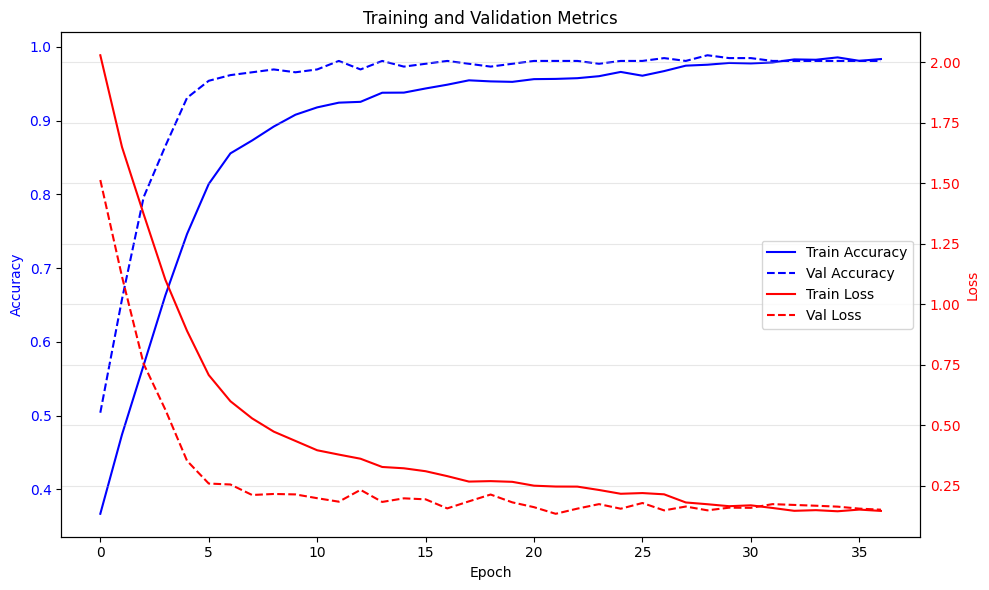

In [43]:
model_crnn.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.3,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_commands\crnn_commands.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history_crnn = model_crnn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]  )

plot_history(history_crnn)

Epoch 1/100
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.7106 - Recall: 0.1713 - accuracy: 0.3690 - auc: 0.7379 - loss: 2.3208
Epoch 1: val_loss improved from inf to 1.54137, saving model to trained_models_commands\resnet8_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - Precision: 0.7120 - Recall: 0.1725 - accuracy: 0.3702 - auc: 0.7391 - loss: 2.3168 - val_Precision: 0.9604 - val_Recall: 0.3731 - val_accuracy: 0.6231 - val_auc: 0.9355 - val_loss: 1.5414 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - Precision: 0.7927 - Recall: 0.3619 - accuracy: 0.5727 - auc: 0.9063 - loss: 1.6516
Epoch 2: val_loss improved from 1.54137 to 0.90798, saving model to trained_models_commands\resnet8_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Precision: 0.7928 - Recall: 0.3621 - accuracy: 0.5728 - auc: 0.9063 - loss: 1.6512 - val_Precision: 0.9559 - val_Recall: 0.7500 - val_accuracy: 0.8731 - val_auc: 0.9886 - val_loss: 0.9080 - learn

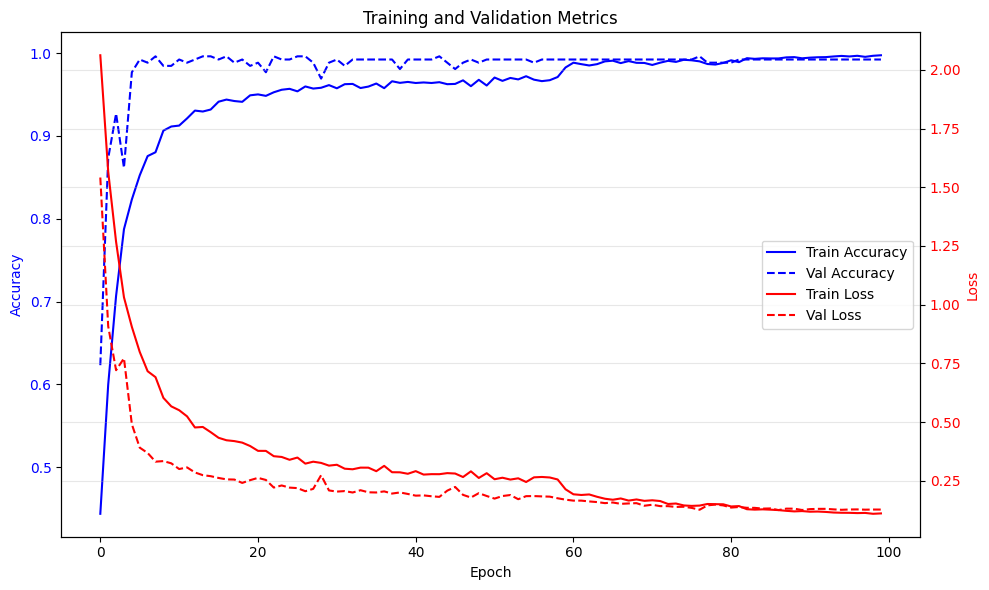

In [44]:
model_resnet8.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.3,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_commands\resnet8_commands.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history_resnet8 = model_resnet8.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]  )

plot_history(history_resnet8)

Epoch 1/100


193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - Precision: 0.7169 - Recall: 0.1602 - accuracy: 0.3575 - auc: 0.6962 - loss: 2.8301
Epoch 1: val_loss improved from inf to 2.20015, saving model to trained_models_commands\resnet14_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - Precision: 0.7187 - Recall: 0.1615 - accuracy: 0.3583 - auc: 0.6972 - loss: 2.8263 - val_Precision: 1.0000 - val_Recall: 0.3192 - val_accuracy: 0.4769 - val_auc: 0.8482 - val_loss: 2.2002 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - Precision: 0.8806 - Recall: 0.3140 - accuracy: 0.4710 - auc: 0.8535 - loss: 2.1871
Epoch 2: val_loss improved from 2.20015 to 1.63251, saving model to trained_models_commands\resnet14_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Precision: 0.8805 - Recall: 0.3140 - accuracy: 0.4710 - auc: 0.8536 - loss: 2.1868 - val_Precision: 0.9266 - val_Recall: 0.3885 - val_accuracy: 0.6462 - val_auc: 0.9485 - val_loss: 1.6325 - learning_rate: 

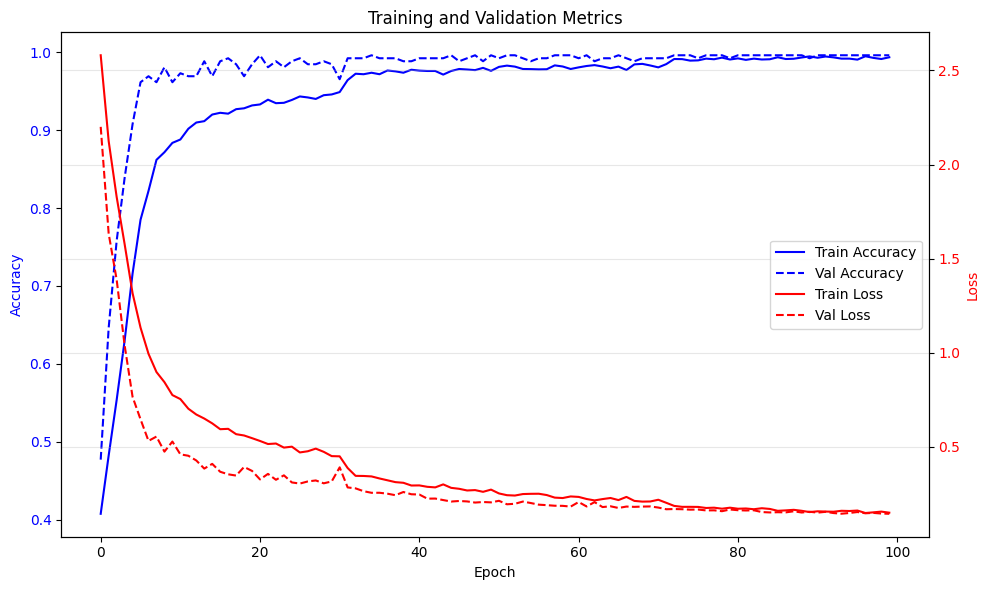

In [45]:
model_resnet14.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.3,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_commands\resnet14_commands.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history_resnet14 = model_resnet14.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]  )

plot_history(history_resnet14)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - Precision: 0.8870 - Recall: 0.5747 - accuracy: 0.7153 - auc: 0.9335 - loss: 0.8824
Epoch 1: val_loss improved from inf to 0.31760, saving model to trained_models_commands\matchboxnet_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - Precision: 0.8873 - Recall: 0.5757 - accuracy: 0.7160 - auc: 0.9338 - loss: 0.8804 - val_Precision: 0.9740 - val_Recall: 0.8654 - val_accuracy: 0.9538 - val_auc: 0.9963 - val_loss: 0.3176 - learning_rate: 0.0010
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - Precision: 0.9699 - Recall: 0.9368 - accuracy: 0.9551 - auc: 0.9982 - loss: 0.1632
Epoch 2: val_loss improved from 0.31760 to 0.13331, saving model to trained_models_commands\matchboxnet_commands.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - Precision: 0.9699 - Recall: 0.9368 - accuracy: 0.9552 - auc: 0.9982 - loss: 0.1631 - val_Precision: 0.9761 - val_Recall: 0.9423 - val_accuracy: 0.9615 - val_auc: 0.9991 - val_loss: 0.133

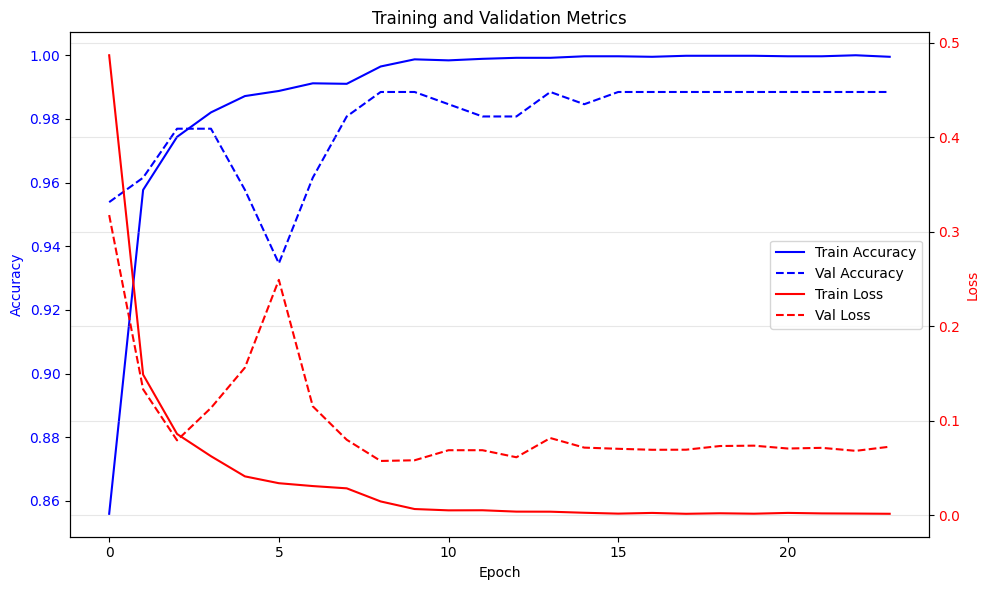

In [46]:
model_matchboxnet.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.3,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_commands\matchboxnet_commands.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history_matchboxnet = model_matchboxnet.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]  )

plot_history(history_matchboxnet)

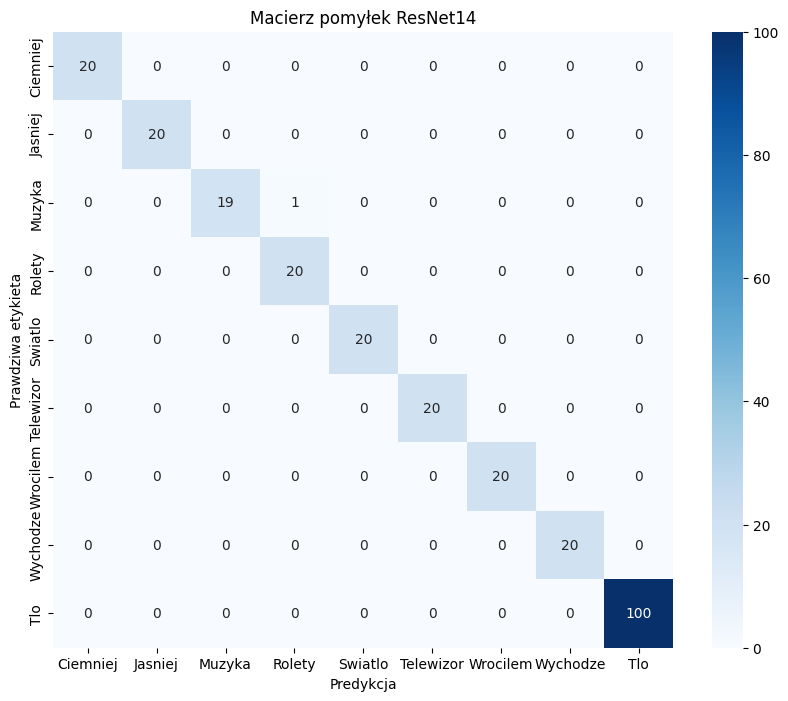

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for audio, label in test_dataset.unbatch(): 
    pred = model_resnet14.predict(tf.expand_dims(audio, axis=0), verbose=0)
    y_true.append(np.argmax(label.numpy()))
    y_pred.append(np.argmax(pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek ResNet14')
plt.show()

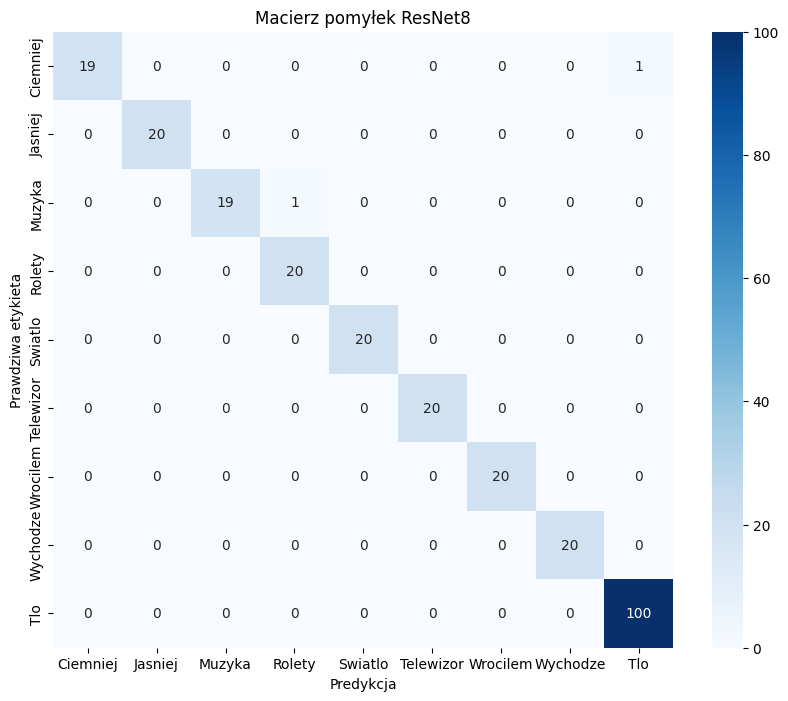

In [48]:
y_true = []
y_pred = []

for audio, label in test_dataset.unbatch(): 
    pred = model_resnet8.predict(tf.expand_dims(audio, axis=0), verbose=0)
    y_true.append(np.argmax(label.numpy()))
    y_pred.append(np.argmax(pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek ResNet8')
plt.show()

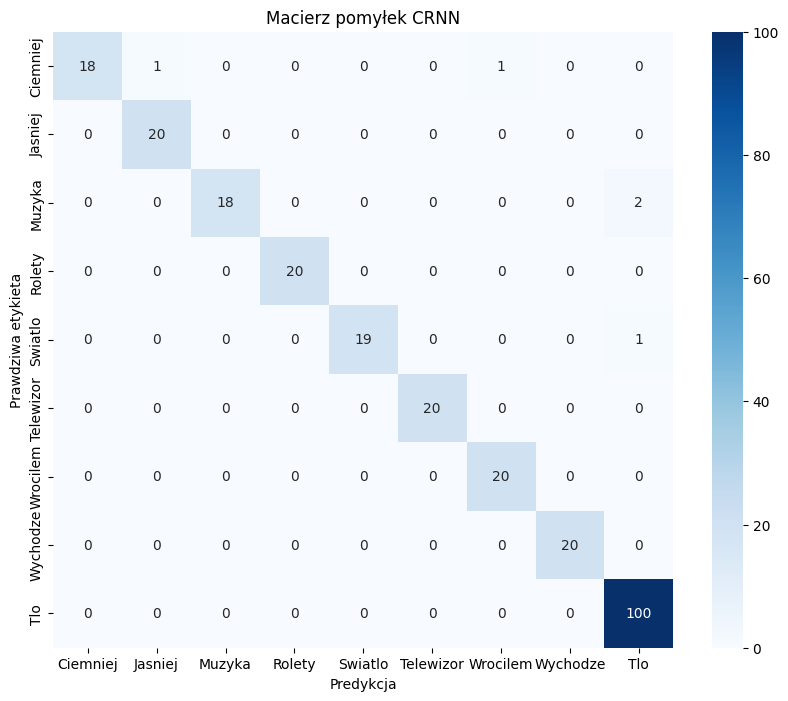

In [49]:
y_true = []
y_pred = []

for audio, label in test_dataset.unbatch(): 
    pred = model_crnn.predict(tf.expand_dims(audio, axis=0), verbose=0)
    y_true.append(np.argmax(label.numpy()))
    y_pred.append(np.argmax(pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek CRNN')
plt.show()

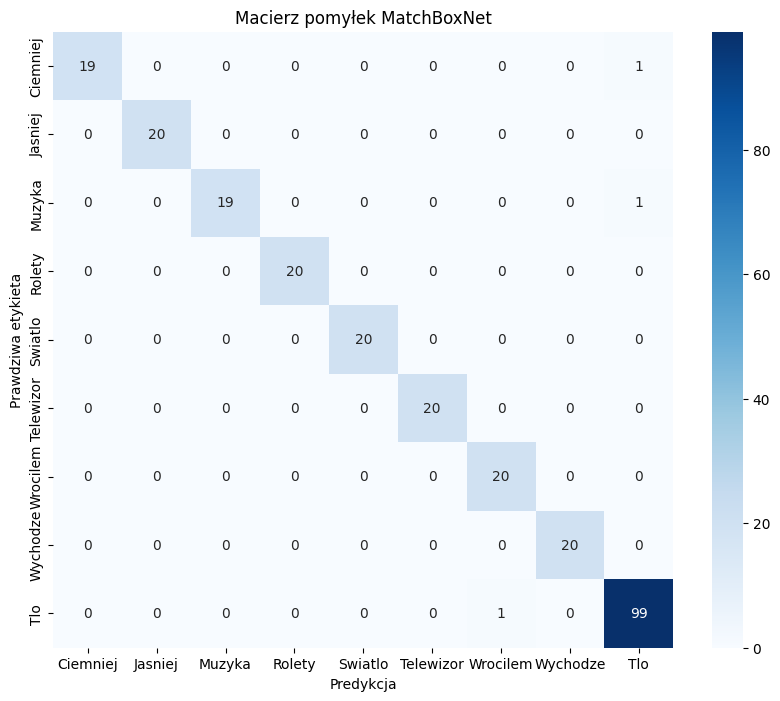

In [50]:
y_true = []
y_pred = []

for audio, label in test_dataset.unbatch(): 
    pred = model_matchboxnet.predict(tf.expand_dims(audio, axis=0), verbose=0)
    y_true.append(np.argmax(label.numpy()))
    y_pred.append(np.argmax(pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=commands, yticklabels=commands)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek MatchBoxNet')
plt.show()